# Ensembles: From Decision Trees to Extra Trees

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor

cars = pd.read_csv('cars.csv')

In [4]:
cars.shape

(261, 8)

In [5]:
cars.tail()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
256,17.0,8,305,130,3840,15,1980,US.
257,36.1,4,91,60,1800,16,1979,Japan.
258,22.0,6,232,112,2835,15,1983,US.
259,18.0,6,232,100,3288,16,1972,US.
260,22.0,6,250,105,3353,15,1977,US.


In [6]:
# Let's check the datatypes of these columns.

cars.dtypes

mpg             float64
 cylinders        int64
 cubicinches     object
 hp               int64
 weightlbs       object
 time-to-60       int64
 year             int64
 brand           object
dtype: object

In [7]:
# Let's look for nulls.

cars.isnull().sum()

mpg             0
 cylinders      0
 cubicinches    0
 hp             0
 weightlbs      0
 time-to-60     0
 year           0
 brand          0
dtype: int64

In [11]:
# Great! Let's map the cubicinches values to floats.
cars[' cubicinches'].apply(float)

ValueError: could not convert string to float: 

In [13]:
# What happened?
cars[cars[' cubicinches']== " "]


,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
40,16.0,6,,105,3897,19,1976,US.
180,19.8,6,,85,2990,18,1980,US.


In [15]:
# Fix the problem!

cars[' cubicinches'].replace(' ', np.nan, inplace=True)

cars[' cubicinches'] = cars[' cubicinches'].apply(float)

cars[' cubicinches'].replace(np.nan,cars[' cubicinches'].mean(), inplace=True)

In [19]:
# What about the weight column?

cars[cars[' weightlbs']== " "]

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
14,19.1,6,225.0,90,,19,1981,US.
33,21.0,6,199.0,90,,15,1971,US.
172,29.0,4,68.0,49,,20,1974,Europe.


In [20]:
# Fixing
cars[' weightlbs'].replace(' ', np.nan, inplace=True)

cars[' weightlbs'] = cars[' weightlbs'].apply(float)

cars[' weightlbs'].replace(np.nan,cars[' weightlbs'].mean(), inplace=True)


In [21]:
# Let's check the correlations of the other features with MPG.

cars.corr()['mpg']

mpg             1.000000
 cylinders     -0.776710
 cubicinches   -0.802379
 hp            -0.774905
 weightlbs     -0.823800
 time-to-60     0.509070
 year           0.550441
Name: mpg, dtype: float64

## Fitting a Decision Tree

In [22]:
X = cars.drop(['mpg', ' brand'], axis=1)
y = cars['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=1)

rt = DecisionTreeRegressor(random_state=1, max_depth=2)
rt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [23]:
rt.score(X_test, y_test)

0.5892766814442141

In [24]:
rt.feature_importances_

array([0.        , 0.        , 0.07920177, 0.79747809, 0.        ,
       0.12332014])

In [25]:
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

//anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


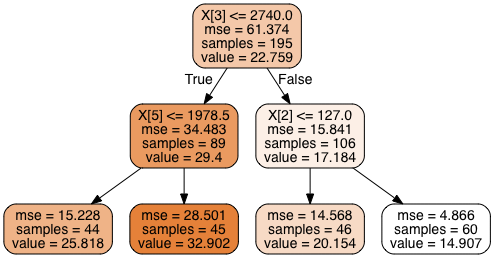

In [26]:
dot_file = StringIO()

export_graphviz(rt, out_file=dot_file, filled=True, rounded=True)

image = pydotplus.graph_from_dot_data(dot_file.getvalue())
Image(image.create_png())

A single decision tree will often overfit your training data. There are steps one can take to help with this, like limiting the "depth" of the nodes. But it's often better to do something else: Plant another tree!

Of course, if a second tree is going to be of any value, it has to be *different from* the first. Here's a good algorithm for achieving that:

## Fitting a Set of Bagged Decision Trees

### Bagging Algorithm

Take a sample of your X_train and fit a decision tree to it. <br/>
Replace the first batch of data and repeat. <br/>
When you've got as many trees as you like, make use of all your individual trees' predictions to come up with some holistic prediction. (Most obviously, we could take the average of our predictions, but there are other methods we might try.)

<br/>

Because we're resampling our data with replacement, we're *bootstrapping*. <br/>
Because we're making use of our many samples' predictions, we're *aggregating*. <br/>
Because we're bootstrapping and aggregating all in the same algorithm, we're *bagging*.

In [27]:
# Instantiate a bagging regressor

bag = BaggingRegressor(n_estimators=100,
                       max_features=X.shape[1],
                       max_samples=20,
                       random_state=1)


In [28]:
# Fit it.

bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=6, max_samples=20, n_estimators=100, n_jobs=None,
                 oob_score=False, random_state=1, verbose=0, warm_start=False)

In [29]:
# Score it.

bag.score(X_test, y_test)

0.8454487935302339

That's a significant improvement in $R^2$! Let's see if we can do even better.

## Fitting a Random Forest

### Random Forest Algorithm

Let's add an extra layer of randomization: Instead of using *all* the features of my model to optimize a branch at each node, I'll just choose a subset of my features.

In [30]:
# Let's try a forest with 100 trees.

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=1)

In [31]:
# Score it.

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8516210778043055

## Fitting a Stand of Extremely Randomized Trees

### Extra Trees Algorithm

Sometimes we might want even one more bit of randomization. Instead of always choosing the *optimal* branching path, we might just choose a branching path at random. If we're doing that, then we've got extremely randomized trees.

In [32]:
# Again let's try 100 trees.
et = ExtraTreesRegressor(n_estimators=100, random_state=1)


In [33]:
# Scoring
et.fit(X_train, y_train)
et.score(X_test, y_test)


0.8572817901031855

In [34]:
# Checking the feature importances

et.feature_importances_

array([0.33590799, 0.15804332, 0.13631364, 0.19342524, 0.02600313,
       0.15030668])

## Gridsearching

In [40]:
# Define param grid.
param_grid = {
    'n_estimators' : [50, 100, 300],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3]
}


In [41]:
# Initialize the gridsearch object with five-fold cross-validation.

gs = GridSearchCV(et, param_grid=param_grid, cv=5)

In [42]:
# Fit it.

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=1,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
               

In [43]:
# Score it.

gs.score(X_test, y_test)

0.8562151373703347

In [50]:
# Get the best parameter values!

gs.best_params_


{'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

In [51]:
# And the best score
gs.best_score_



0.8624070922926678

In [52]:
# And the best estimator

gs.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=3, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

## Building a Model that Takes Raw Data as Input

Suppose we go with the best estimator according to our gridsearch results. If we want our model to be able to make predictions of MPG for an uncleaned row of input, we'll need to be able to clean the row before modeling.

The main cleaning moves that we made above were to fix the problems in the cubicinches and the weightlbs columns. We'll also need to drop the columns that don't belong in the model.

Let's write functions that will take care of those problems.

In [53]:
# Reloading the dataset

cars_relo = pd.read_csv('cars.csv')

In [54]:
def clean(df):
    for col in [' cubicinches', ' weightlbs']:
        df[col].replace(' ', np.nan, inplace=True)
        df[col] = df[col].map(float)
        df[col].replace(np.nan, df[col].mean(), inplace=True)
    return df

In [55]:
def drop(df):
    return df.drop(['mpg', ' brand'], axis=1)

In [56]:
def model_predict(df):
    df_clean = clean(df)
    df_preds = drop(df)
    et = ExtraTreesRegressor(min_samples_leaf=3,
                       min_samples_split=2,
                       n_estimators=100).fit(df_preds, df['mpg'])
    return et.predict(df_preds).reshape(-1, 1)

In [57]:
model_predict(cars_relo)

array([[13.92021429],
       [33.49626389],
       [16.38252381],
       [14.87837302],
       [31.62586548],
       [19.30598333],
       [13.29337143],
       [14.16128571],
       [24.67136861],
       [37.50158214],
       [33.37968496],
       [34.28189841],
       [14.84816667],
       [12.94085714],
       [22.89204123],
       [16.78585476],
       [35.24897341],
       [16.44959444],
       [23.73876032],
       [24.32509762],
       [37.87793968],
       [23.13848968],
       [21.4732881 ],
       [17.05544048],
       [38.52528929],
       [33.1659631 ],
       [31.36658929],
       [14.64061364],
       [18.60907897],
       [33.88233333],
       [25.35249603],
       [17.23836548],
       [22.62714048],
       [20.28178849],
       [31.13772103],
       [21.00648488],
       [26.98258929],
       [23.63968562],
       [17.38714286],
       [20.52129441],
       [17.29161786],
       [14.45064286],
       [18.37535397],
       [18.39358929],
       [14.6852938 ],
       [31